In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import pickle

In [2]:
data=pickle.load(open('processed_data.p', "rb" ))
seat_data=data.loc[data['seatName']=='B5_9_1_05']
seat_data=seat_data.sort_values(['Datetime'])
seat_data=seat_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
seat_data.set_index('Datetime',inplace=True)
seat_data.index.freq='10T'

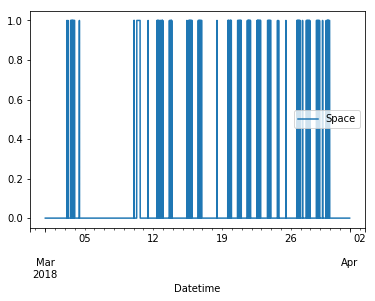

In [3]:
seat_data.plot()

In [20]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,explained_variance_score
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX

def acc_score(data,show_res):
    n_data= data[data['Forecast'].notnull()]

    y_true=n_data['Space']
    y_pred=n_data['Forecast']
    RMSE=rmse(y_true,y_pred)
    MAE=mean_absolute_error(y_true,y_pred)
    R2=r2_score(y_true,y_pred)
    MAPE=np.mean(np.abs((y_true-y_pred)/y_true))*100
    
    if show_res==True:
        print(' ERROR MEASURES ')
        print('Root Mean Squared Error: ', RMSE)
        print('Mean Absolute Error: ', MAE)
        print('Mean Absolute Percent Error: ', MAPE)
        print('R2 score: ', R2)
    
    return RMSE,MAE,R2,MAPE

def build_model(data,train_data,param,seasonal_param,show_res):
    data_forecast=data.copy()
   
    model=SARIMAX(train_data,order=param)
    model_fit=model.fit()
    
    df=model_fit.forecast(steps=144)
  #  print(df)
   # print(len(data_forecast),len(df))
    data_forecast['Forecast']=df
    if show_res==True:
        print(model_fit.summary())
        
    return data_forecast,model_fit.aic



def grid_search(data,train_data):
    import itertools
    import warnings
    warnings.filterwarnings("ignore")
    
    p=d=q = range(0,3)
    
    pdq=list(itertools.product(p,d,q))
    #PDQ=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    arima_model=list()
    for param in pdq:
       # for seasonal_param in PDQ:
            try:

                data_forecast,model_aic=build_model(data,train_data,param,(0,0,0,144),False)
                RMSE,MAE,R2,MAPE=acc_score(data_forecast,False)
                arima_model.append([param,model_aic,RMSE,MAE,MAPE,R2])  
                
            except:
                continue
    columns=['pdq','AIC','RMSE','MAE','MAPE','R2']
    grid_res=pd.DataFrame(arima_model,columns=columns)
    grid_res=grid_res.sort_values(by=['RMSE','MAE','MAPE'],ascending=True)
    print(len(arima_model),(len(grid_res)))

    return grid_res



from sklearn.model_selection import TimeSeriesSplit

def grid_searchCV(orig_data):
    import itertools
    import warnings
    warnings.filterwarnings("ignore")
    
    p=d=q = range(0,2)
    
    pdq=list(itertools.product(p,d,q))
    PDQ=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    arima_model=list()
    for param in pdq:
       # for seasonal_param in PDQ:
            #try:
                data=orig_data.reset_index()
                ini_train_data=data.loc[data['Date']<'2015-08-01']
                data_to_split=data.loc[data['Date']>='2015-08-01']
                tss=TimeSeriesSplit(n_splits=6)
                
                result_list=list()
                for train_index,test_index in tss.split(data_to_split):

                    X_train, X_test = data_to_split.iloc[train_index], data_to_split.iloc[test_index]
                    X_train=pd.concat([ini_train_data,X_train])
                    X_train.set_index('Date',inplace=True)
                    data_forecast,model_aic=build_model(orig_data,X_train,param,(0,0,0),False)
                    RMSE,MAE,R2,MAPE=acc_score(data_forecast,False)
                    result_list.append([model_aic,RMSE,MAE,MAPE,R2])
                    
                model_avg_result=np.mean(result_list,0)
                
                arima_model.append([param,model_avg_result[0],
                                    model_avg_result[1],model_avg_result[2],model_avg_result[3],model_avg_result[4]])  
                
           # except:
             #   continue
    columns=['pdq','AIC','RMSE','MAE','MAPE','R2']
    grid_res=pd.DataFrame(arima_model,columns=columns)
    grid_res=grid_res.sort_values(by=['RMSE','MAE','MAPE'],ascending=True)
    print(len(arima_model),(len(grid_res)))

    return grid_res

In [21]:
train_data=seat_data.loc[seat_data.index<'2018-03-25']
train_data['Space']=train_data['Space'].astype('float64')
grid_res=grid_search(seat_data,train_data)
display(grid_res)

20 20


,pdq,AIC,RMSE,MAE,MAPE,R2
16,"(2, 1, 1)",-1136.890816,0.117749,0.014752,inf,-0.012327
9,"(1, 1, 2)",-1131.552089,0.117800,0.014312,inf,-0.013210
8,"(1, 1, 1)",-1123.165267,0.117819,0.014151,inf,-0.013540
14,"(2, 0, 2)",-1168.145609,0.117849,0.013913,inf,-0.014055
13,"(2, 0, 1)",-1161.628377,0.117850,0.013902,inf,-0.014070
3,"(0, 1, 2)",-1072.274574,0.117851,0.013893,inf,-0.014076
6,"(1, 0, 2)",-1131.189832,0.117851,0.013889,inf,-0.014084
2,"(0, 1, 1)",-984.081804,0.117851,0.013889,inf,-0.014085
5,"(1, 0, 1)",-1093.262997,0.117851,0.013889,inf,-0.014085
4,"(1, 0, 0)",-798.221177,0.117851,0.013889,100.000000,-0.014085


In [22]:
print(len(seat_data),len(train_data))

4464 3456


In [23]:
data_forecast,model_aic=build_model(seat_data,train_data,(2, 1, 1),(0,0,0),False)

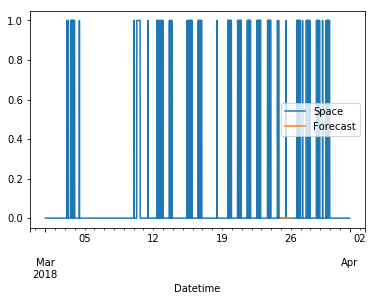

In [24]:
data_forecast.plot();